In [ ]:
import os
import pickle
import nltk
from data import Preprocessor, Vocabulary


In [2]:
# 1. 加载数据,做tokenize和clean
nltk.data.find('tokenizers/punkt')
nltk.data.find('tokenizers/punkt_tab')
print('正在加载和预处理数据...')
preprocessor = Preprocessor()

# 加载训练数据
train_files = [os.path.join('dataset','train_100k.jsonl')]
train_data = preprocessor.load_data(train_files)
# 在这里做tokenize和clean
train_pairs = preprocessor.prepare_data(train_data)

print(f'加载完成，训练数据对数量: {len(train_pairs)}')


正在加载和预处理数据...


/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


加载完成，训练数据对数量: 99983


## 保存 已经clean和tokenize的 train_pairs

In [3]:
# 保存为 JSONL 文件
import json 
with open('dataset/train_100k_pairs.jsonl', 'w', encoding='utf-8') as f:
    for src, tgt in train_pairs:
        json_line = json.dumps({"src": src, "tgt": tgt}, ensure_ascii=False)
        f.write(json_line + '\n')

## 从文件中读取 train_pairs

In [2]:
# 读取 JSONL 文件
import json 
train_pairs = []

with open('dataset/train_100k_pairs.jsonl', 'r', encoding='utf-8') as f:
    for line in f:
        line = line.strip()
        if line:
            record = json.loads(line)
            train_pairs.append((record["src"], record["tgt"]))

# 构建词汇表

In [87]:
# 2. 构建词表
print('正在构建词汇表...')
src_vocab = Vocabulary('zh', max_size=24000)
tgt_vocab = Vocabulary('en', max_size=24000)
# 为训练数据构建词汇表
for src, tgt in train_pairs:
    src_vocab.add_sentence(src)
    tgt_vocab.add_sentence(tgt)
# 构建词汇表
src_vocab.build_vocab()
tgt_vocab.build_vocab()

正在构建词汇表...


## 统计量和统计图

In [122]:
def count_unk_in_dataset(train_pairs, vocab, language='tgt'):
    total_tokens = 0
    unk_tokens = 0
    unk_word_set = set()

    for i in range(len(train_pairs)):
        if language == 'src':
            text = train_pairs[i][0]  # src_text
        else:
            text = train_pairs[i][1]  # tgt_text

        tokens = text.split()
        for word in tokens:
            total_tokens += 1
            if word not in vocab.word2idx:
                unk_tokens += 1
                unk_word_set.add(word)
    
    print(f"[{language}] Total tokens: {total_tokens}")
    print(f"[{language}] UNK tokens: {unk_tokens} ({100 * unk_tokens / total_tokens:.2f}%)")
    print(f"Unique OOV words: {len(unk_word_set)}")
    return unk_word_set

# 检查目标语言的 OOV 情况
tgt_oov = count_unk_in_dataset(train_pairs, tgt_vocab, 'tgt')
# 可选：打印前10个 OOV 词
print("Sample OOV words:", list(tgt_oov)[:10])


# 检查源头语言的 OOV 情况
src_oov = count_unk_in_dataset(train_pairs, src_vocab, 'src')
# 可选：打印前10个 OOV 词
print("Sample OOV words:", list(src_oov)[:10])

[tgt] Total tokens: 2533480
[tgt] UNK tokens: 27232 (1.07%)
Unique OOV words: 22585
Sample OOV words: ['unguided', '1813', 'ocean-based', 'classics', 'hollowness', '15,455', 'mopped', 'escorts', 'hadjievs', 'medical-school']
[src] Total tokens: 2365029
[src] UNK tokens: 39346 (1.66%)
Unique OOV words: 33277
Sample OOV words: ['Tversky', '空前绝后', '填埋', '第二份', '外族', 'NXP半导体公司', '在成', '蠵龟', '正反面', '洛克菲勒']


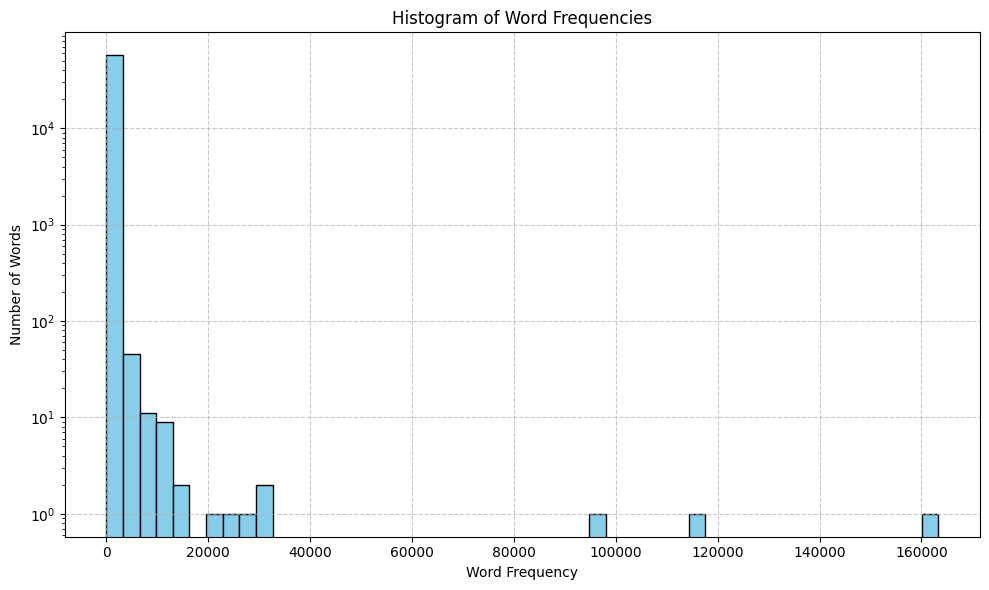

In [123]:
import matplotlib.pyplot as plt


# 获取词频列表（只取出现次数）
word_counts = list(src_vocab.word_count.values())

# 绘制直方图
plt.figure(figsize=(10, 6))
plt.hist(word_counts, bins=50, color='skyblue', edgecolor='black')
plt.title('Histogram of Word Frequencies')
plt.xlabel('Word Frequency')
plt.ylabel('Number of Words')
plt.yscale('log')  # 可选：使用对数刻度更清晰地显示长尾分布
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## 保存词汇表

In [92]:
# 保存词表为pkl文件
src_vocab_path = os.path.join('models/saved', 'src_vocab.pkl')
tgt_vocab_path = os.path.join('models/saved', 'tgt_vocab.pkl')

with open(src_vocab_path, 'wb') as f:
    pickle.dump(src_vocab, f)

with open(tgt_vocab_path, 'wb') as f:
    pickle.dump(tgt_vocab, f)

print(f'源语言词表已保存到: {src_vocab_path}')
print(f'目标语言词表已保存到: {tgt_vocab_path}')

源语言词表已保存到: models/saved/src_vocab.pkl
目标语言词表已保存到: models/saved/tgt_vocab.pkl


## 读取词汇表

In [ ]:
# 读取词表从pkl文件
src_vocab_path = os.path.join('models/saved', 'tgt_vocab.pkl')
tgt_vocab_path = os.path.join('models/saved', 'src_vocab.pkl')
with open(src_vocab_path, 'rb') as f:
    src_vocab= pickle.load(f)
with open(tgt_vocab_path, 'rb') as f:
    tgt_vocab= pickle.load(f)

# 构造预训练的词嵌入向量矩阵

### 源语言词嵌入向量矩阵

In [99]:
# 读取预训练词向量
from utils.embedding import PretrainedEmbedding
src_pretrained_emb = PretrainedEmbedding('merge_sgns_bigram_char300.txt','char300')
src_pretrained_vocab = src_pretrained_emb.get_vocab()


加载Character300词向量: merge_sgns_bigram_char300.txt
Character300词向量加载完成，词汇量: 1348378，向量维度: 200


In [119]:
# 生成源语言词向量矩阵
"""      目前的实现中 unkown pad eos sos 均为零向量
        由于词向量文件中通常不包含这些特殊标记词
        这些词的向量将在模型训练时随机初始化吗？
"""
src_embedding_matrix = src_pretrained_emb.get_embedding_matrix(
    src_vocab.word2idx, 
    300
)

嵌入矩阵生成完成，词汇表大小: 24000，匹配到词向量: 21027


### 目标语言词嵌入向量矩阵

In [117]:
tgt_pretrained_emb = PretrainedEmbedding('wiki_giga_2024_200_MFT20_vectors_seed_2024_alpha_0.75_eta_0.05_combined.txt','glove')
tgt_pretrained_vocab = tgt_pretrained_emb.get_vocab()

200

In [120]:
# 生成目标语言词向量矩阵
tgt_embedding_matrix = tgt_pretrained_emb.get_embedding_matrix(
    tgt_vocab.word2idx, 
    200
)

嵌入矩阵生成完成，词汇表大小: 24000，匹配到词向量: 22099


### 保存到文件

In [121]:
# 保存词向量矩阵为pkl文件
src_embedding_path = os.path.join('models/saved', 'src_embedding.pkl')
tgt_embedding_path = os.path.join('models/saved', 'tgt_embedding.pkl')

with open(src_embedding_path, 'wb') as f:
    pickle.dump(src_embedding_matrix, f)

with open(tgt_embedding_path, 'wb') as f:
    pickle.dump(tgt_embedding_matrix, f)

### 从文件读取词向量嵌入矩阵

In [ ]:
# 读取词嵌入从pkl文件
src_embedding_path = os.path.join('models/saved', 'src_embedding.pkl')
tgt_embedding_path = os.path.join('models/saved', 'tgt_embedding.pkl')
with open(src_embedding_path, 'rb') as f:
    src_embedding= pickle.load(f)
with open(tgt_embedding_path, 'rb') as f:
    tgt_embedding= pickle.load(f)